In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns

from network_classes import MNIST_net

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth':1.2,
                     'xtick.major.size': 6,
                     'xtick.major.width': 1.2,
                     'ytick.major.size': 6,
                     'ytick.major.width': 1.2,
                     'legend.frameon': False,
                     'legend.handletextpad': 0.1,
                     'figure.figsize': [14.0, 4.0],})

In [2]:
tensor_normalize = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.1307],std=[0.3081])])

MNIST_train = torchvision.datasets.MNIST(root='MNIST_data/',train=True,transform=tensor_normalize,download=False)
MNIST_test = torchvision.datasets.MNIST(root='MNIST_data/',train=False,transform=tensor_normalize,download=False)

batch_size = 32
dataloader = torch.utils.data.DataLoader(MNIST_train,
                                         batch_size=batch_size,
                                         shuffle=True)

dataloader_test = torch.utils.data.DataLoader(MNIST_test,
                                              batch_size=10000,
                                              shuffle=True)

In [3]:
# all_images = torch.zeros(len(dataloader),784)

# for i,(image,label) in enumerate(dataloader):
#     all_images[i] = image.flatten()

# print(torch.mean(all_images))
# print(torch.std(all_images))

Label = 3
torch.Size([32, 1, 28, 28])


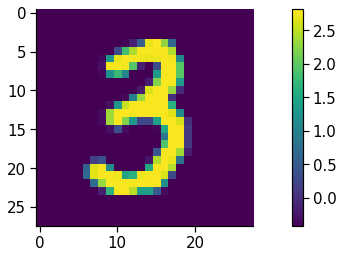

In [4]:
# Print example image

# inputs, classes = next(iter(dataloader))   
# plt.imshow(inputs[0,0,:,:])
for image, label in dataloader:
    plt.imshow(image[0,0])
    plt.colorbar()
    print(f'Label = {label[0]}')
    print(image.shape)
    break

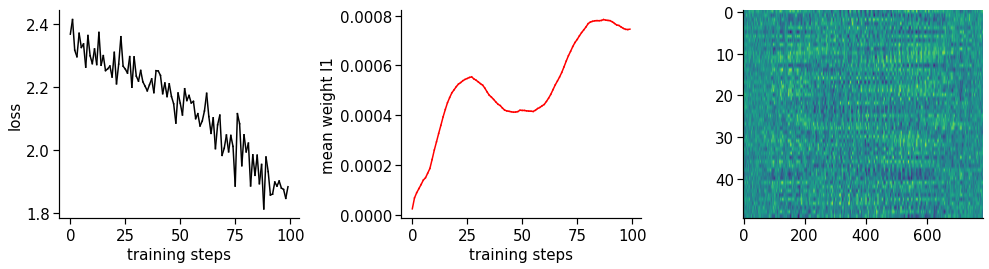

Final accuracy = 62.779998779296875%


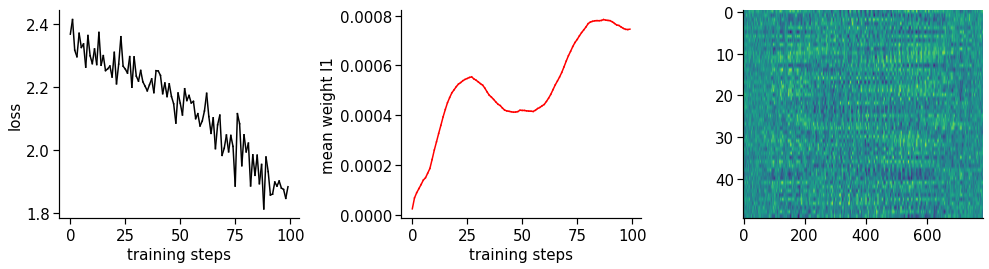

In [5]:
torch.manual_seed(123)

model = MNIST_net(batch_size, dales_law=False)
model.train(dataloader,
            dataloader_test,
            num_epochs = 1,
            max_batch = 100,
            lr = 0.0005,
            plot_dynamic_loss=True)

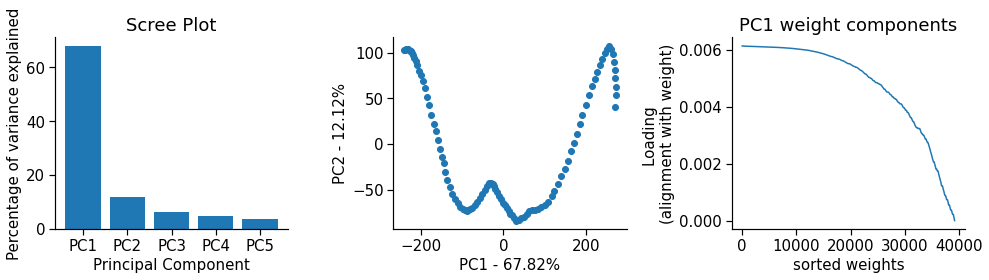

In [6]:
# PCA of the weight space
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing

w1 = model.weight_history1.flatten(start_dim=1)
w1 = preprocessing.scale(w1) # center the data (mean=0, std=1)
pca = PCA(n_components=5)
pca.fit(w1)
w1_pca = pca.transform(w1)


# Plot explained variance
fig, ax = plt.subplots(1,3)
explained_variance = pca.explained_variance_ratio_
percent_exp_var = np.round(explained_variance*100,decimals=2)
labels = ['PC' + str(x) for x in range(1,len(percent_exp_var)+1)]
ax[0].bar(x=range(1,len(percent_exp_var)+1), height=percent_exp_var, tick_label=labels)
ax[0].set_ylabel('Percentage of variance explained')
ax[0].set_xlabel('Principal Component')
ax[0].set_title('Scree Plot')

# Plot weights in PC space
PC1 = w1_pca[:,0]
PC2 = w1_pca[:,1]
ax[1].scatter(PC1,PC2)
ax[1].set_xlabel(f'PC1 - {percent_exp_var[0]}%')
ax[1].set_ylabel(f'PC2 - {percent_exp_var[1]}%')

# Plot loading scores for PC1 to determine which/how many weights are important for variance along PC1
sorted_loadings = -np.sort(-np.abs(pca.components_[0])) # Loadings sorted in descending order of abs magnitude
sorted_idx = np.argsort(-np.abs(pca.components_[0]))

most_important_weights_flat = sorted_idx[0:10] #
most_important_weights_idx = [] # index of important weights in original weight matrix

ax[2].plot(sorted_loadings)
ax[2].set_xlabel('sorted weights')
ax[2].set_ylabel('Loading \n(alignment with weight)')
ax[2].set_title('PC1 weight components')

plt.tight_layout()
plt.show()

In [7]:
# Get weights in gridplane defined by PC dimensions
num_points = 20
delta_PC1 = np.max(PC1) - np.min(PC1)
delta_PC2 = np.max(PC2) - np.min(PC2)
PC1_range = np.linspace(np.min(PC1)-delta_PC1, np.max(PC1)+delta_PC1, num_points)
PC2_range = np.linspace(np.min(PC2)-delta_PC2, np.max(PC2)+delta_PC2, num_points)

PC1_mesh, PC2_mesh = np.meshgrid(PC1_range,PC2_range)

# Convert PC coordinates into full weight vectors
meshgrid_points = np.concatenate([PC1_mesh.reshape(1,num_points**2),PC1_mesh.reshape(1,num_points**2)]).T

gridpoints_weightspace = pca.inverse_transform(meshgrid_points)


# Get weight trajectory projection onto PC plane
w1_proj = pca.inverse_transform(w1_pca).reshape(100,500,784)

# Compute loss for projected weight trajectory point, and compare with actual trajectory loss


ValueError: shapes (400,2) and (5,39200) not aligned: 2 (dim 1) != 5 (dim 0)

In [ ]:
gridpoints_weights.shape

In [ ]:
meshgrid_points.shape